# DG tutorial

In [9]:
#define imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import quad
from numpy.linalg import inv

The equation we wish to solve can be written
$$
\partial_t \mathbf{a} = \mathbf{M}^{-1} \cdot (c \mathbf{K} \cdot \mathbf{a} - \mathbf{f}).
$$
In the cell below we define each of the quantities on the right-hand side.

In [31]:
#define CFL
CFL = 0.05

#define number of timesteps, TS
TS = 250

#set up grid
xMax = 1.
xMin = 0.

#define number of elements
N = 75

#define size of a cell, dx
dx = (xMax-xMin)/N
dt = CFL * dx

#index cells from k = 0 to N; cell boundary is at (k*dx, [k+1]*dx); define array of boundaries cbound
cbound = [k*dx for k in range(N+1)]

#define wave speed c
c = 1.

In [32]:
#define basis functions
def psi0(xi):
    return 1-xi

def psi1(xi):
    return xi

#define analytic derivatives of basis functions
def psi0P(xi):
    return -1

def psi1P(xi):
    return 1

#define Jacobian
def J(xi):
    return dx

#define x(k, xi)
def x(k, xi):
    return (k+xi)*dx

#define mass matrix; since the mass matrix is just a constant, this function
#only needs to be called once and the result should be stored for the evolution
def Mij():
    M00 = quad(lambda xi: J(xi)*psi0(xi)*psi0(xi), 0, 1)[0]
    M01 = quad(lambda xi: J(xi)*psi0(xi)*psi1(xi), 0, 1)[0]
    M10 = M01
    M11 = quad(lambda xi: J(xi)*psi1(xi)*psi1(xi), 0, 1)[0]
    return [[M00, M01],[M10, M11]]

#define stiffness matrix; again, it is constant, so we only need to evaluate this
#function once and the result should be stored for the evolution
def Kij():
    K00 = quad(lambda xi: psi0P(xi)*psi0(xi), 0, 1)[0]
    K01 = quad(lambda xi: psi0P(xi)*psi1(xi), 0, 1)[0]
    K10 = quad(lambda xi: psi1P(xi)*psi0(xi), 0, 1)[0]
    K11 = quad(lambda xi: psi1P(xi)*psi1(xi), 0, 1)[0]
    return [[K00, K01],[K10, K11]]

#define q tilde, the approximate solution; this is a function of the cell index
#k, xi, and the vector of weights a_n; a_n[k] = (a_0, a_1) for element k
def qt(k, xi, a):
    return ( a[k, 0]*psi0(xi) + a[k, 1]*psi1(xi))

#define flux (boundary) term; this is a function of position, so take in a cell
#index k as an argument and the solution vector a_n
def f(k, a_n):
    f0 = -c*qt(k-1, 1, a_n)
    f1 = c*qt(k, 1, a_n)
    return [f0, f1]

#define RHS function
def RHS(k, a_n, Minv, K):
    return np.dot(Minv, c*np.dot(K, a_n[k])-f(k,a_n))

#define evolve() function which returns a_np1 given a_n
def evolve(a_n, a_np1, Minv, K):
    #for each element compute a at the next time level
    for k in range(N):
        a_np1[k] = a_n[k] + dt*RHS(k, a_n, Minv, K)

    return a_np1

#evolve system TS timesteps; takes in # of timesteps TS,
#coefficient vector at initial time a_n, and empty
#coefficient vector at advanced time a_np1
def evolve_TS_steps(TS, a_n, a_np1):
    #compute mass matrix, stiffness matrix, inverse of
    #mass matrix; do this just once per evolution,
    #since these are all constant matrices
    K    = Kij()
    M    = Mij()
    Minv = inv(M)
    
    for n in range(TS):
        a_np1 = evolve(a_n, a_np1, Minv, K)
        #copy a_np1 into a_n for next timestep
        a_n = a_np1



In [33]:
#define a_n = solution vector at time level n; should have shape (N, 2), where
#N is the number of elements (i.e. we have a_0, a_1 for each element)
a_n = np.ones((N,2))

#define a_np1 = solution vector at time level n+1; same shape as a_n
a_np1 = np.ones((N,2))

In [34]:
#define initial data.  Notice that for cell k, a_{0,k} = q(x_L)
#and a_{1,k} = q(x_R)
def q_ID(x):
    mu = 0.5
    sigma = 0.05
    return np.exp(-(x-mu)**2./sigma**2.)

#compute the coefficients a_n[k] corresponding to projecting analytic ID
#from q_ID(x) onto the basis (psi_0, psi_1)
def compute_ID_a(a_n):
    for k in range(N):
        a_n[k,0] = q_ID(cbound[k])
        a_n[k,1] = q_ID(cbound[k+1])

    return a_n

#plot solution given coefficient vector a_n; takes an optional matplotlib
#style string
def plot_soln(a_n, styleString=''):
    #xi in each element
    xi = np.linspace(0., 1, 10)

    #plot approximate solution qtilde(x)
    for k in range(N):
        pl.plot(x(k,xi), qt(k, xi, a_n), styleString)



Solve the system

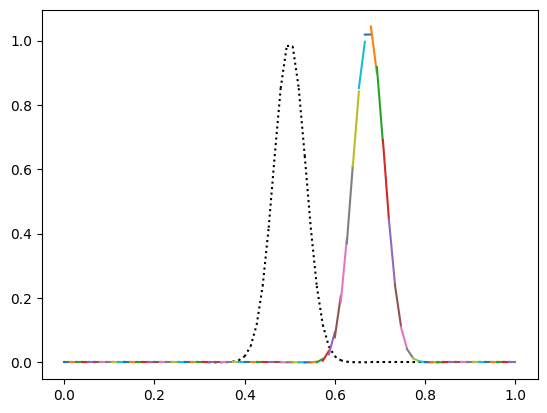

In [35]:
#compute initial data
a_n = compute_ID_a(a_n)
#plot initial data as a black dotted line
plot_soln(a_n, 'k:')

#compute solution after TS timesteps
evolve_TS_steps(TS, a_n, a_np1)

#plot solution after TS timesteps
plot_soln(a_np1)
pl.show()